# Coagulation Basic 5: Super Droplet Method

**BETA VERSION**

*It seems like the underlying SDM method is wrong**

**Introduction**

In aerosol science, understanding particle-particle interactions is crucial for predicting the evolution of particle size distributions. One such interaction is **coagulation**, where two particles collide and merge into a larger particle. Modeling coagulation accurately can be computationally expensive, especially when tracking individual particles. 

The **super droplet method** is a technique that allows for the efficient simulation of coagulation in a computationally feasible manner. It represents a large number of real particles with a smaller number of computational particles (super droplets), each carrying a statistical weight that reflects the number of real particles it represents.

This notebook provides a step-by-step guide to simulating coagulation using the super droplet method with a particle-resolved approach.

**Setup and Imports**

We'll start by importing the necessary libraries and setting up the environment.


In [22]:
# %% particle resolved coagulation example
import numpy as np  # For numerical operations and array manipulations
import matplotlib.pyplot as plt  # For plotting graphs and visualizations

# Import specific modules from the particula package
from particula.dynamics.coagulation import brownian_kernel
from particula.dynamics.coagulation import super_droplet_method

from particula.particles.properties.lognormal_size_distribution import (
    lognormal_sample_distribution,
)

## Generating Distribution

In this section, we generate a sample particle size distribution following a lognormal distribution. The lognormal distribution is commonly used in aerosol science to describe particle size distributions. 

**Coagulation Kernel**

We also calculate the Brownian coagulation kernel for these particles, which quantifies the probability of coagulation between particles of different sizes.

**Random seed**

We set a random seed to ensure reproducibility of the results.

In [23]:
# lognormal spacing

radius_bins = np.logspace(
    -9, -6, num=20
)  # Define the radius bins for the distribution
mass_bins = (
    4 / 3 * np.pi * radius_bins**3 * 1000
)  # Calculate the mass of the particles in the bins

kernel = brownian_kernel.brownian_coagulation_kernel_via_system_state(
    radius_particle=radius_bins,
    mass_particle=mass_bins,
    temperature=298.15,
    pressure=101325,
)  # Calculate the Brownian coagulation kernel for the radius bins

random_generator = np.random.default_rng(12345)

**Sampling the Particle Distribution**

We then sample particles from the lognormal distribution. These particles will be sorted by size to prepare for the coagulation step.

In [24]:
# %% sample particle distribution
particle_radius = lognormal_sample_distribution(
    mode=np.array([1e-8, 1e-7]),
    geometric_standard_deviation=np.array([1.4, 1.4]),
    number_of_particles=np.array([5000, 1000]),
    number_of_samples=10000,
)
particle_radius = np.sort(particle_radius)
particles_original = particle_radius.copy()

## Coagulation Step

In the coagulation step, particles collide and merge over a given time step. The super droplet method efficiently simulates this process by adjusting the particle sizes and concentrations based on the calculated kernel and the specified volume and time step.

In [25]:
# %% Coagulation step

delta_t = 1  # time step in seconds

random_concentration = np.random.uniform(1, 10, size=particle_radius.size)
particle_concentration = (
    np.ones_like(particle_radius) * random_concentration * 1e6
)  # particles per m^3
particle_concentration = particle_concentration.astype(np.float64)
volume_sim = 1  # m^3

particle_radius_1, particle_concentration_1 = (
    super_droplet_method.super_droplet_coagulation_step(
        particle_radius=particle_radius,
        particle_concentration=particle_concentration,
        kernel=kernel,
        kernel_radius=radius_bins,
        volume=volume_sim,
        time_step=delta_t,
        random_generator=random_generator,
    )
)

volume_final = np.power(particle_radius_1, 3)
volume_concentration_final = volume_final * particle_concentration_1
volume_total_final = np.sum(volume_concentration_final)

print(f"Final volume: {volume_total_final}")
print(f"Final number of particles: {np.sum(particle_concentration_1)}")

Final volume: 1.6866138333522715e-11
Final number of particles: 39420946809.99734


**Plotting the New Distribution**

Finally, we plot the particle size distribution before and after coagulation. This visualization helps us understand the effect of the coagulation process on the particle size distribution.

The histogram bins are weighted by the number of particles in each bin to reflect the super droplet method's representation of real particles.


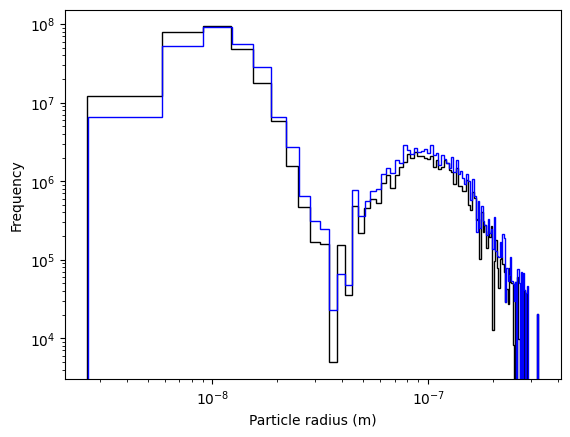

In [26]:
# %% plot new distribution
fig, ax = plt.subplots()
ax.hist(
    particles_original,
    weights=particle_concentration,
    bins=100, histtype="step", color="black", density=True
)
ax.hist(
    particle_radius,
    weights=particle_concentration_1,
    bins=100, histtype="step", color="blue", density=True
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Frequency")
plt.show()

## Direct Time Stepping

With the first coagulation step completed, we can now proceed to the next time step. We repeat the coagulation process for the new particle distribution, updating the particle sizes and concentrations accordingly. This iterative approach allows us to simulate the evolution of the particle size distribution over time.

Here we use a simple for loop to perform multiple coagulation steps. In practice, more sophisticated time-stepping methods may be used to improve efficiency and accuracy.

In [27]:
# Initial distribution for the simulation
particles_i = particle_radius

particle_concentration_i = particle_concentration

# Define the time array for the simulation
time_array = np.linspace(
    start=0, stop=1000, num=100
)  # Time span of 1000 seconds
time_interval = (
    time_array[1] - time_array[0]
)  # Time interval between each step

# Array to store the distribution at each time step
particles_matrix = np.zeros([len(time_array), len(particles_i)])
concentration_matrix = np.zeros([len(time_array), len(particles_i)])

particles_matrix[0, :] = particles_i
concentration_matrix[0, :] = particle_concentration_i
# Simulate the coagulation process over time
for i, dpa in enumerate(time_array):
    if i > 0:

        particles_i, particle_concentration_i = (
            super_droplet_method.super_droplet_coagulation_step(
                particle_radius=particles_i,
                particle_concentration=particle_concentration_i,
                kernel=kernel,
                kernel_radius=radius_bins,
                volume=volume_sim,
                time_step=time_interval,
                random_generator=random_generator,
            )
        )
        # Ensure no negative concentrations (set to zero if less than zero)
        particles_i[particles_i < 0] = 0

    # Store the updated distribution for the current time step
    particles_matrix[i, :] = particles_i
    concentration_matrix[i, :] = particle_concentration_i

**Plotting the Final Distribution**

Finally, we plot the particle size distribution at the end of the simulation. This visualization provides insights into how the particle size distribution evolves over time due to coagulation.

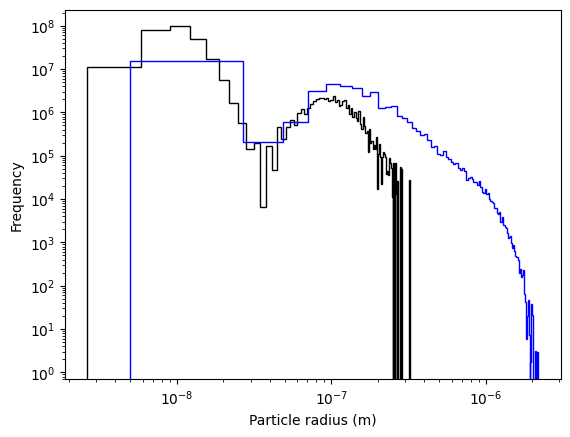

In [28]:
fig, ax = plt.subplots()
ax.hist(
    particles_original,
    weights=particle_concentration,
    bins=100,
    histtype="step",
    color="black",
    density=True,
)
ax.hist(
    particles_matrix[-1, :],
    weights=concentration_matrix[-1, :],
    bins=100,
    histtype="step",
    color="blue",
    density=True,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Frequency")
plt.show()

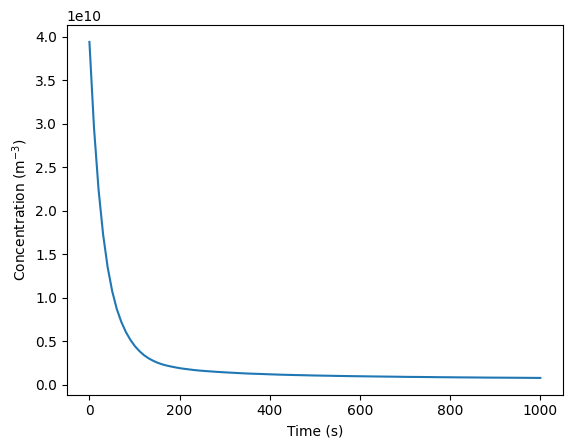

In [29]:
# total number of particles
total_concentration = np.sum(concentration_matrix, axis=1)

fig, ax = plt.subplots()
ax.plot(time_array, total_concentration)
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Concentration (m$^{-3}$)")
plt.show()

## Conclusion

This notebook demonstrated the use of the super droplet method to simulate particle coagulation in a computationally efficient manner. By representing multiple real particles with fewer computational particles, we can model complex aerosol dynamics over time without the need for excessive computational resources.

**Seems like it is over estimating the coagulation rate. Need to follow-up**
